# COMP90051 Workshop 10
## Nuclear Power Plant in Stan
***

In this worksheet, we'll revisit the nuclear power plant model from lectures. 
Recall that the model describes the probability of an alarm sounding conditional on the following variables:

- `FA`: whether the alarm is faulty
- `HT`: whether the temperature is high (i.e. reactor is in meltdown)
- `FG`: whether the temperature gauge is faulty
- `HG`: whether the temperature gauge reads high

A plate diagram for the model is given below. 
Note that we've explicitly included the probability tables as parameters in the model. 
We're also taking a more Bayesian approach by putting a prior over the entries in the probability tables.



Our goal is to infer the probability tables based on observations (assuming all variables are observed).
We'll use Stan to do the inference. If you don't already have this package, you'll need to install the python library. Note there are some [compatibility restrictions](https://pystan.readthedocs.io/en/latest/faq.html) with various platforms, notably for use on Windows requires [WSL2](https://pystan.readthedocs.io/en/latest/faq.html).

In [13]:
import sys
!{sys.executable} -m pip install pystan arviz

Ok, with that done, we can import the packages we need.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # pretty plotting style
import stan            # Python interface for STAN
import pandas as pd    # reading CSV
import arviz as az     # plotting functionality for Bayesian inference

## 1. Loading observations
Let's begin by loading the observations.
The `nuclear.csv` file contains 10,000 observations for all variables (HT, FA, FG, HG, AS) as rows.
Note that it is completely observed, i.e., all instances have values for all variables.
We load the file into a dataframe, and cast the binary observations to 0/1 integers.

In [4]:
df = pd.read_csv("nuclear.csv")
df = df.astype(int) # cast from bool to int
df.head()

,HT,FA,FG,HG,AS
0,0,0,1,1,1
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


## 2. Model definition
Stan models are specified using the Stan Modelling Language: a custom language with a syntax similar to C.
It's recommended to store models in `.stan` text files.
Our nuclear model is specified in `nuclear.stan`, which we've reproduced below.

In [5]:
nuclear_code = """
data {
  int<lower=1> N; // number of observations
  // for each of these, 0 means false, 1 means true
  int<lower=0, upper=1> HT[N];  // whether core temperature high
  int<lower=0, upper=1> FG[N];  // whether gauge is faulty
  int<lower=0, upper=1> FA[N];  // whether alarm is faulty
  int<lower=0, upper=1> HG[N];  // whether gauge reads high
  int<lower=0, upper=1> AS[N];  // whether alarm sounds

  real<lower=0> ALPHA; // alpha to use for beta distributions
  real<lower=0> BETA; // beta to use for beta distributions
}

parameters {
  //probability table for each variable
  real<lower=0, upper=1> p_ht;
  real<lower=0, upper=1> p_fg;  
  real<lower=0, upper=1> p_fa;
  real<lower=0, upper=1> p_hg[2,2];
  real<lower=0, upper=1> p_as[2,2];
}

model {
  // priors for probability table parameters
  p_ht ~ beta(ALPHA, BETA);
  p_fg ~ beta(ALPHA, BETA);
  p_fa ~ beta(ALPHA, BETA);
  for (i in 1:2) {
    for (j in 1:2) {
      p_hg[i, j] ~ beta(ALPHA, BETA); 
      p_as[i, j] ~ beta(ALPHA, BETA);
    }
  }
  
  // likelihood of observing data
  for (n in 1:N) {
    HT[n] ~ bernoulli(p_ht);
    FG[n] ~ bernoulli(p_fg);
    FA[n] ~ bernoulli(p_fa);
    // +1 in indexing below because Stan arrays count from 1
    HG[n] ~ bernoulli(p_hg[HT[n]+1, FG[n]+1]);
    AS[n] ~ bernoulli(p_as[FA[n]+1, HG[n]+1]);
  }
}
"""

There are three blocks in this file:

- the *data* block allows us to pass external variables (from R) into Stan. Note that variables are statically typed.
- the *parameters* block defines the sampling space: i.e. the parameters we'd like to infer.
- the *model* block is where we define the posterior distribution.


## 3. Preparing data
When using the interface for Stan, we must pass the variables in the *data* block as a named list.
The names should match those used in the `.stan` file.
This is easy to do: we simply convert the dataframe to a list, then concatenate it with the `ALPHA`, `BETA` and `N` parameters.

In [6]:
nuclear_data = df.to_dict(orient='list')
nuclear_data["ALPHA"] = 1
nuclear_data["BETA"] = 1
nuclear_data["N"] = df.shape[0]

---
**Question:** What is the effect of setting `ALPHA` and `BETA` to 1? 

## 4. Running Stan
To run inference, we call Stan, passing a reference to our model specification file, in addition to the data. In Stan inference is performed using sampling, used to compute the posterior over the model parameters given the training data, i.e., each sample is $\theta^{(s)} \sim P(\theta|X)$. Given a large number of parameter samples, we can understand properties of the model, and use them to perform various tasks.

We also specify the number of iterations to run, which is related to the number of posterior samples we'd like.
Note that not all of the iterations yield usable samples: some of them are discarded during a warmup period (before the Markov chain has converged to the posterior) - this is discussed in lecture 20.

For details of these functions, please see [the pystan API](https://pystan.readthedocs.io/en/latest/reference.html) and [the cmdstan API](https://mc-stan.org/docs/2_26/cmdstan-guide/mcmc-intro.html) (pystan is a Python wrapper for the cmdstan tool, which has considerably more detailed documentation).

In [9]:
import nest_asyncio
nest_asyncio.apply()

posterior = stan.build(nuclear_code, data=nuclear_data)
fit = posterior.sample(num_chains=2, num_samples=1000)

Building...

/Users/tcohn/opt/anaconda3/lib/python3.8/codeop.py:141: RuntimeWarning: coroutine 'build.<locals>.go' was never awaited
  codeob = compile(source, filename, symbol, self.flags, 1)



Building: 19.7s, done.Messages from stanc:
  The parameter p_as has no priors.
  The parameter p_fa has no priors.
  The parameter p_fg has no priors.
  The parameter p_hg has no priors.
  The parameter p_ht has no priors.
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2

Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (

Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (

Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (

Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (2/4000)
Sampling:   0% (

Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   8% (300/4000)
Sampling:   

Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  18% (700/4000)
Sampling:  20% (800/4000)
Sampling:  20% (800/4000)
Sampling:  20% (800/4000)
Sampling:  20% (800/4000)
Sampling:  20% (800/4000)
Sampling:  20% (800/4000)
Sampling:  20% (800/4000)
Sampling:  20% (800/4000)
Sampling:  20% (800/4000)
Sampling:  22% (900/4000)
Sampling:  22% (900/4000)
Sampling:  2

Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  32% (1300/4000)
Sampling:  35% (1400/4000)
Sampling:  35% (1400/4000)
Sampling:  35% (1400/4000)
Sampling:  38% (1500/4000)
Sampling:  38% (1500/4000)
Sampling:  38% (1500/4000)
Sampling:  38% (1500/4000)
Sampling:  38% (1500/4000)
Sampling:  38% (1500/4000)
Sampling:  38% (1500/4000)
Sampling:  38% (1500/4000)
Sampling:  38% (1500/4000)
Sampling:  38% (1500/4000)
Sampling:  38% (1500/4000)
S

Sampling:  50% (2002/4000)
Sampling:  50% (2002/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
Sampling:  53% (2101/4000)
S

Sampling:  70% (2800/4000)
Sampling:  70% (2800/4000)
Sampling:  70% (2800/4000)
Sampling:  70% (2800/4000)
Sampling:  70% (2800/4000)
Sampling:  70% (2800/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
Sampling:  72% (2900/4000)
S

Sampling:  88% (3500/4000)
Sampling:  88% (3500/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  90% (3600/4000)
Sampling:  92% (3700/4000)
Sampling:  92% (3700/4000)
Sampling:  92% (3700/4000)
Sampling:  92% (3700/4000)
Sampling:  92% (3700/4000)
Sampling:  92% (3700/4000)
Sampling:  92% (3700/4000)
Sampling:  92% (3700/4000)
Sampling:  92% (3700/4000)
Sampling:  92% (3700/4000)
Sampling:  92% (3700/4000)
Sampling:  92% (3700/4000)
S

  Adjust your expectations accordingly!


Calling the `print` function on the output gives us a summary of the posterior distribution for each parameter.

In [10]:
print(fit)

<stan.Fit>
Parameters:
    p_ht: ()
    p_fg: ()
    p_fa: ()
    p_hg: (2, 2)
    p_as: (2, 2)
Draws: 2000


The "fit" is a sequence of samples of the model parameters, stored in a `pandas` dataframe. You can inspect the samples directly:

In [17]:
# get a pandas dataframe holding the samples
df = fit.to_frame()
# summarise the samples
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
lp__,2000.0,-19030.120232,2.359807,-1.903962e+04,-19031.500701,-19029.810803,-19028.430767,-19024.977819
accept_stat__,2000.0,0.921360,0.101295,7.147850e-02,0.894557,0.950650,0.984465,1.000000
stepsize__,2000.0,0.443636,0.011014,4.326244e-01,0.432624,0.443636,0.454647,0.454647
treedepth__,2000.0,2.999500,0.116217,2.000000e+00,3.000000,3.000000,3.000000,4.000000
n_leapfrog__,2000.0,7.446000,1.893905,3.000000e+00,7.000000,7.000000,7.000000,15.000000
divergent__,2000.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
energy__,2000.0,19035.639981,3.343249,1.902651e+04,19033.295972,19035.241890,19037.671868,19047.680759
p_ht,2000.0,0.103136,0.003058,9.307193e-02,0.101046,0.103045,0.105195,0.115188
p_fg,2000.0,0.198295,0.003994,1.841057e-01,0.195462,0.198171,0.201010,0.211653


We can also plot the posterior with Bayesian credible intervals.

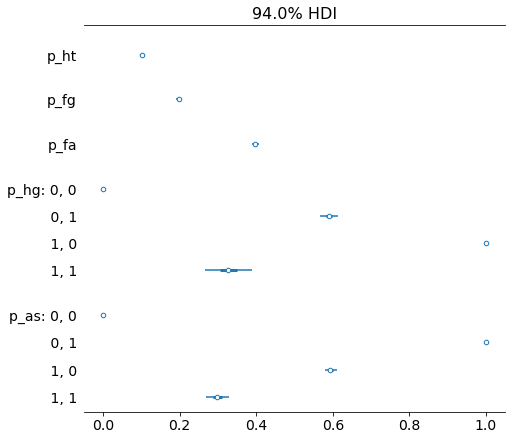

In [11]:
az.plot_forest(fit, kind="forestplot", combined=True, 
               ridgeplot_overlap=1.5, figsize=(7, 6))
plt.show()

In practice, we should inspect trace plots to ensure the Markov chains are mixing well.
However this is beyond the scope of COMP90051. For a summary of how this is done, see [this tutorial](https://m-clark.github.io/bayesian-basics/diagnostics.html#monitoring-convergence)

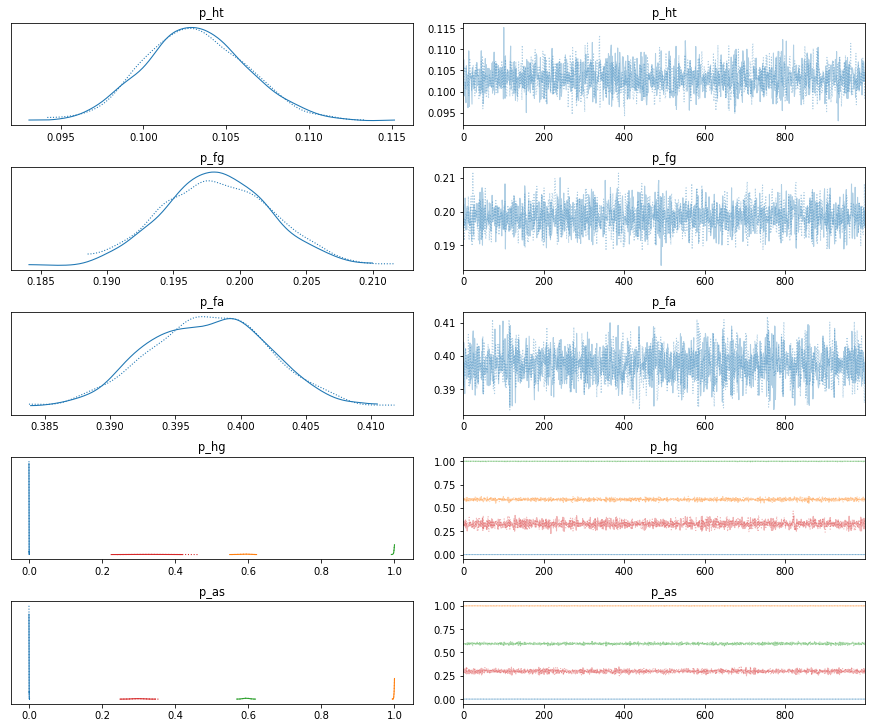

In [12]:
az.plot_trace(fit)
plt.show()